In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# Data preprocessing

In [ ]:
# Load the dataframe.
sales_data = pd.read_csv('sales_data.csv')
sales_data.info()

In [ ]:
# Convert 'date' column to datetime
sales_data['date'] = pd.to_datetime(sales_data['date'])

In [ ]:
# Group sales by day and store
sales_data = sales_data.groupby(['date','store'])['sales'].sum().reset_index()

print(sales_data)


In [ ]:
# Create a column for the previous day's sales (lagged sales)
sales_data['previous_day_sales'] = sales_data.groupby(['store'])['sales'].shift(1)

# Drop rows with NaN in 'previous_day_sales' (first day of each store-item combination)
sales_data = sales_data.dropna()
sales_data = round(sales_data)

print(sales_data)

           date  store  sales  previous_day_sales
1    2022-01-02      1     83                94.0
3    2022-01-03      1    121                83.0
4    2022-01-03      2    233                66.0
5    2022-01-04      1     58               121.0
6    2022-01-04      2    203               233.0
...         ...    ...    ...                 ...
1662 2024-06-28      1    525              1182.0
1663 2024-06-28      2    175               186.0
1664 2024-06-29      1    391               525.0
1665 2024-06-29      2    249               175.0
1666 2024-06-30      1   1087               391.0

[1665 rows x 4 columns]


In [ ]:
# Extract time-based features from the date
sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['day'] = sales_data['date'].dt.day
sales_data['dayofweek'] = sales_data['date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
sales_data['is_weekend'] = sales_data['dayofweek'].isin([5, 6]).astype(int)  # 1 if Saturday or Sunday, 0 otherwise
print(sales_data)

# Model application and evaluation functions

In [ ]:
# Function to evaluate the model
def evaluate_model(y_test, y_pred):
    # Compute square error
    se = np.linalg.norm(y_test - y_pred)
    mse, std_se = np.mean(se), np.std(se)
    # Compute absolute error
    ae = np.abs(y_test - y_pred)
    mae, std_ae = np.mean(ae), np.std(ae)
    # Compute "percetange error"
    pe = np.abs((y_test - y_pred) / y_test)
    mpe, std_pe = np.mean(pe) * 100, np.std(pe) * 100
    # Compute relative error
    re = ae / (np.max(y_test) - np.min(y_test))
    mre, std_re = np.mean(re) * 100, np.std(re) * 100
    return (mse, std_se), (mae, std_ae), (mpe, std_pe), (mre, std_re)

In [ ]:
def train_and_test_monthly(data, test_month, model, month_name):
    # Split into training (before test_month) and test data (test_month)
    label_encoder_store = LabelEncoder()
    label_encoder_item = LabelEncoder()
    data['store'] = label_encoder_store.fit_transform(data['store'])


    train_data = data[data['date'] < test_month]
    test_data = data[(data['date'] >= test_month) & (data['date'] < test_month + pd.DateOffset(months=1))]

    # Define features (inputs) and target (sales)
    features = ['store','year', 'month', 'day','dayofweek', 'is_weekend', 'previous_day_sales']
    X_train, y_train = train_data[features], train_data['sales']
    X_test, y_test = test_data[features], test_data['sales']

    # Train the model with data until the test month
    model.fit(X_train, y_train)

    # Make predictions for the test month
    y_pred = model.predict(X_test)

    # Evaluate the error
    (mse, std_se), (mae, std_ae), (mpe, std_pe), (mre, std_re) = evaluate_model(y_test, y_pred)

    # Create a DataFrame for results
    results_df = pd.DataFrame({
        'date': test_data['date'],
        'store': test_data['store'],
        'Ventas Reales': y_test,
        'Ventas Previstas': y_pred,

      })


    # Save the results to a CSV file
    results_df.to_excel(f'results_{month_name}.xlsx', index=False)

    # Print the metrics
    print(f'Results for {test_month.strftime("%Y-%m")}:')
    print(f'MSE: {mse:.2f}, MAE: {mae:.2f} +- {std_ae:.2f}, MPE: {mpe:.2f} +- {std_pe:.2f}%, MRE: {mre:.2f} +- {std_re:.2f}%')

    return model

# RANDOM FOREST APLICATION

In [ ]:
# Initialize the RandomForest model
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)

APRIL

In [ ]:
# Predict for April 2024
test_month = pd.to_datetime('2024-04-01')
model = train_and_test_monthly(sales_data, test_month, model_RF, 'April_RF_2024')

MAY

In [ ]:
# Predict for May 2024 (train with April data)
test_month = pd.to_datetime('2024-05-01')
model = train_and_test_monthly(sales_data, test_month, model_RF, 'May_RF_2024')

JUNE

In [ ]:
# Predict for June 2024 (train with May data)
test_month = pd.to_datetime('2024-06-01')
model = train_and_test_monthly(sales_data, test_month, model_RF, 'June_RF_2024')

IMPORTANCE OF EVERY FEATURE

In [ ]:
# Get feature importance
feature_importance = model.feature_importances_
for i, feature in enumerate(['store','year', 'month', 'day','dayofweek', 'is_weekend', 'previous_day_sales']):
    print(f"Importance of {feature}: {feature_importance[i]}")
# Create a bar plot of feature importance
plt.figure(figsize=(16, 6))
plt.bar(['store','year', 'month', 'day','dayofweek', 'is_weekend', 'previous_day_sales'], feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

# MULTIPLE LINEAR REGRESSION APLICATION

In [ ]:
# Initialize the LinearRegression model
model_MLR = LinearRegression()


Abril

In [ ]:
# Predict for April 2024 (train with April data)
test_month = pd.to_datetime('2024-04-01')
model = train_and_test_monthly(sales_data, test_month, model_MLR, 'April_MLR_2024')
print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mayo

In [ ]:
# Predict for May 2024 (train with April data)
test_month = pd.to_datetime('2024-05-01')
model = train_and_test_monthly(sales_data, test_month, model_MLR, 'May_MLR_2024')
print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Junio

In [ ]:
# Predict for June 2024 (train with May data)
test_month = pd.to_datetime('2024-06-01')
model = train_and_test_monthly(sales_data, test_month, model_MLR, 'June_MLR_2024')
print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Feature Importance:
store: 0.6040383541746202
year: 0.0795793290929343
month: 0.012291396670481791
day: 0.022824923868161876
dayofweek: 0.07608885269501171
is_weekend: 0.20030675762271943
previous_day_sales: 0.004870385876070624


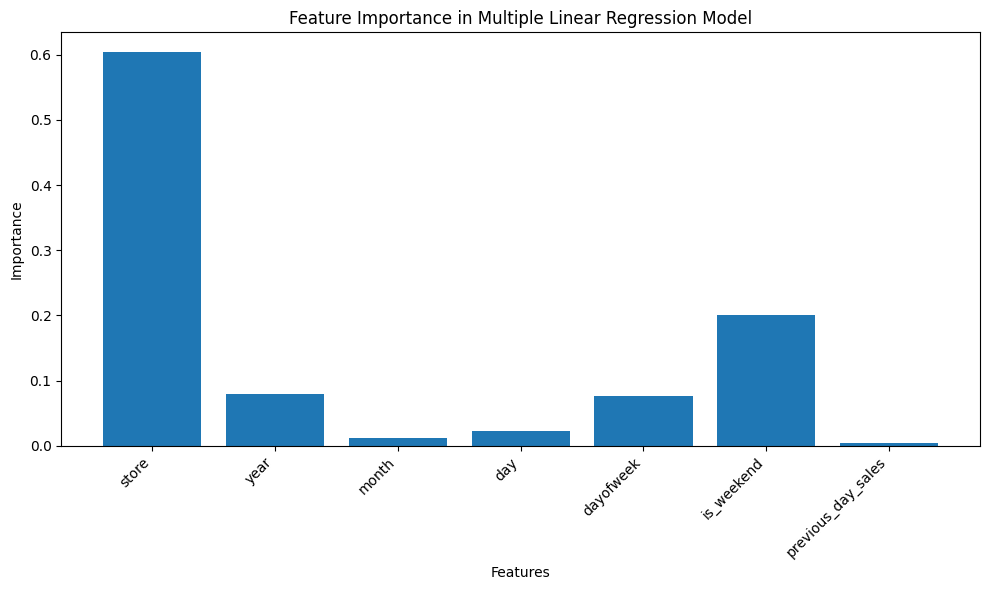

In [ ]:
# Get the coefficients of the model
coefficients = model.coef_

# Create a dictionary to store feature importance
feature_importance = {}
features = ['store','year', 'month', 'day','dayofweek', 'is_weekend', 'previous_day_sales']
for i, feature in enumerate(features):
    feature_importance[feature] = abs(coefficients[i])


# Optionally, you can normalize the importance values to sum to 1:
total_importance = sum(feature_importance.values())
normalized_feature_importance = {feature: importance / total_importance for feature, importance in feature_importance.items()}
print("Feature Importance:")
for feature, importance in normalized_feature_importance.items():
    print(f"{feature}: {importance}")
# Assuming normalized_feature_importance is defined as in the previous code
plt.figure(figsize=(10, 6))
plt.bar(normalized_feature_importance.keys(), normalized_feature_importance.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Multiple Linear Regression Model')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()




# XGBREGRESSOR APLICATION

In [ ]:
# Initialize the XGBoost model
model_XGB = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')


Abril

In [ ]:
# Predict for April 2024 (train with April data)
test_month = pd.to_datetime('2024-04-01')
model = train_and_test_monthly(sales_data, test_month, model_XGB, 'April_XGB_2024')

Mayo

In [ ]:
# Predict for May 2024 (train with April data)
test_month = pd.to_datetime('2024-05-01')
model = train_and_test_monthly(sales_data, test_month, model_XGB, 'May_XGB_2024')

Junio

In [ ]:
# Predict for June 2024 (train with May data)
test_month = pd.to_datetime('2024-06-01')
model = train_and_test_monthly(sales_data, test_month, model_XGB, 'June_XGB_2024')

In [ ]:

# Get feature importance from the trained XGBoost model
feature_importance = model.feature_importances_

# Create a dictionary to store feature importance
feature_importance_dict = {}
features = ['store','year', 'month', 'day','dayofweek', 'is_weekend', 'previous_day_sales']
for i, feature in enumerate(features):
    feature_importance_dict[feature] = feature_importance[i]

# Print the feature importance
print("Feature Importance (XGBoost):")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_dict.keys(), feature_importance_dict.values())
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in XGBoost Model')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# Comparison between models

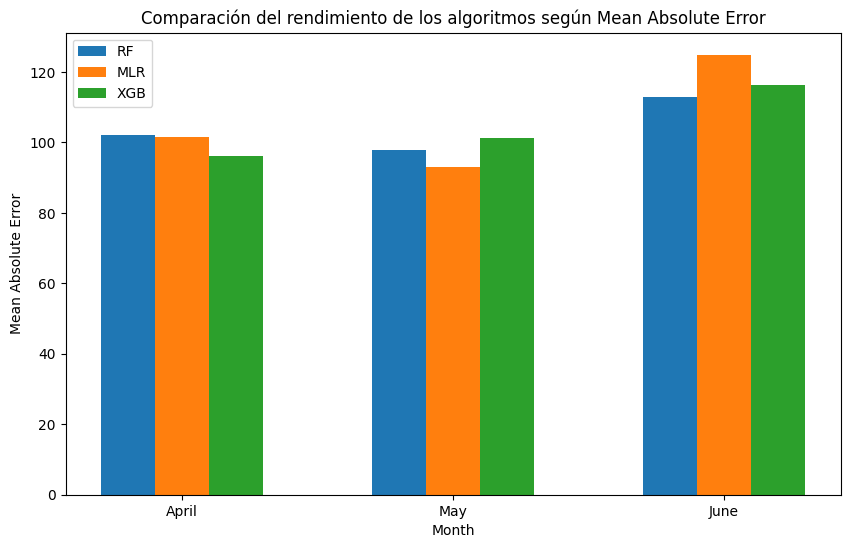

In [ ]:
# Function to calculate mean error for a specific month and model
def calculate_mean_error(month_name, model_name):
    try:
        df = pd.read_excel(f'results_{month_name}_{model_name}_2024.xlsx')
        # Assuming 'Ventas Reales' and 'Ventas Previstas' are your actual and predicted values columns
        df['Error'] = abs(df['Ventas Reales'] - df['Ventas Previstas'])
        mean_error = df['Error'].mean()
        return mean_error
    except FileNotFoundError:
        return None


months = ['April', 'May', 'June']
models = ['RF', 'MLR', 'XGB']

# Create a dictionary to store mean errors for each model and month
mean_errors = {model: [] for model in models}

# Calculate mean errors for each month and model
for month in months:
    for model in models:
        mean_error = calculate_mean_error(month, model)
        if mean_error is not None:
            mean_errors[model].append(mean_error)
        else:
            mean_errors[model].append(None)

# Create a bar plot to compare mean errors across models and months
bar_width = 0.2
index = range(len(months))

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.bar([x + i * bar_width for x in index], mean_errors[model], width=bar_width, label=model)

ax.set_xlabel('Month')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Comparación del rendimiento de los algoritmos según Mean Absolute Error')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(months)
ax.legend()

plt.show()


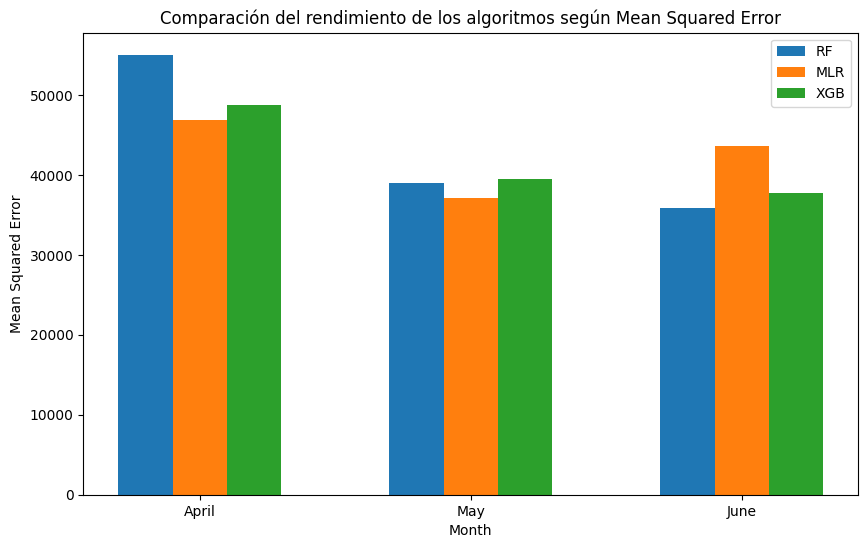

In [ ]:

# Function to calculate mean error for a specific month and model
def calculate_mean_error(month_name, model_name, error_metric):
    try:
        df = pd.read_excel(f'results_{month_name}_{model_name}_2024.xlsx')
        # Assuming 'Ventas Reales' and 'Ventas Previstas' are your actual and predicted values columns
        df['Error'] = (df['Ventas Reales'] - df['Ventas Previstas']) ** 2  # Calculate squared error
        mean_error = df['Error'].mean()
        return mean_error
    except FileNotFoundError:
        return None


months = ['April', 'May', 'June']
models = ['RF', 'MLR', 'XGB']

# Create a dictionary to store mean errors for each model and month
mean_errors = {model: [] for model in models}

# Calculate mean errors for each month and model
for month in months:
    for model in models:
        mean_error = calculate_mean_error(month, model, 'MSE')
        if mean_error is not None:
            mean_errors[model].append(mean_error)
        else:
            mean_errors[model].append(None)

# Create a bar plot to compare mean errors across models and months
bar_width = 0.2
index = range(len(months))

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.bar([x + i * bar_width for x in index], mean_errors[model], width=bar_width, label=model)

ax.set_xlabel('Month')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparación del rendimiento de los algoritmos según Mean Squared Error')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(months)
ax.legend()

plt.show()


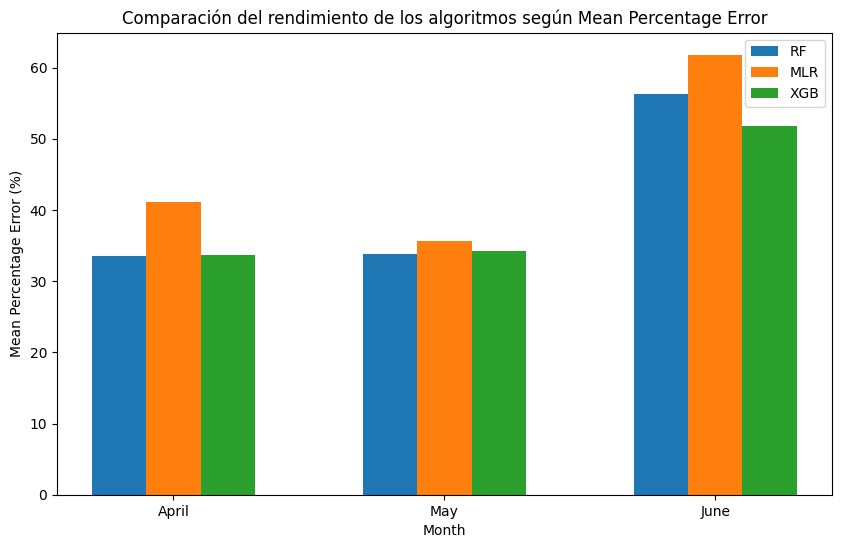

In [ ]:
# prompt: i want to compare the models with mpe

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Function to calculate mean error for a specific month and model
def calculate_mean_error(month_name, model_name):
    try:
        df = pd.read_excel(f'results_{month_name}_{model_name}_2024.xlsx')
        # Assuming 'Ventas Reales' and 'Ventas Previstas' are your actual and predicted values columns
        df['Error'] = np.abs((df['Ventas Reales'] - df['Ventas Previstas']) / df['Ventas Reales']) * 100
        mean_error = df['Error'].mean()
        return mean_error
    except FileNotFoundError:
        return None


months = ['April', 'May', 'June']
models = ['RF', 'MLR', 'XGB']

# Create a dictionary to store mean errors for each model and month
mean_errors = {model: [] for model in models}

# Calculate mean errors for each month and model
for month in months:
    for model in models:
        mean_error = calculate_mean_error(month, model)
        if mean_error is not None:
            mean_errors[model].append(mean_error)
        else:
            mean_errors[model].append(None)

# Create a bar plot to compare mean errors across models and months
bar_width = 0.2
index = range(len(months))

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.bar([x + i * bar_width for x in index], mean_errors[model], width=bar_width, label=model)

ax.set_xlabel('Month')
ax.set_ylabel('Mean Percentage Error (%)')
ax.set_title('Comparación del rendimiento de los algoritmos según Mean Percentage Error')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(months)
ax.legend()

plt.show()


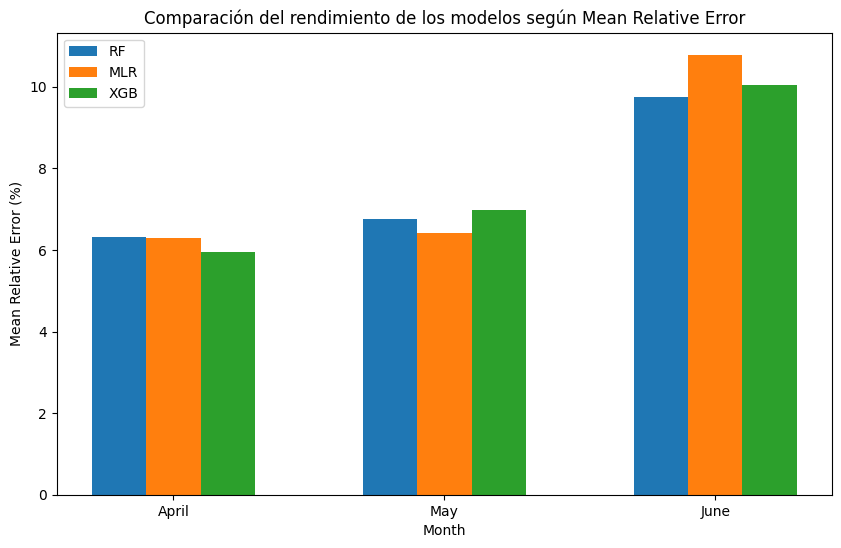

In [ ]:
# Function to calculate mean error for a specific month and model
def calculate_mean_error(month_name, model_name):
    try:
        df = pd.read_excel(f'results_{month_name}_{model_name}_2024.xlsx')
        # Assuming 'Ventas Reales' and 'Ventas Previstas' are your actual and predicted values columns
        df['Error'] = np.abs(df['Ventas Reales'] - df['Ventas Previstas']) / (np.max(df['Ventas Reales']) - np.min(df['Ventas Reales'])) * 100
        mean_error = df['Error'].mean()
        return mean_error
    except FileNotFoundError:
        return None


months = ['April', 'May', 'June']
models = ['RF', 'MLR', 'XGB']

# Create a dictionary to store mean errors for each model and month
mean_errors = {model: [] for model in models}

# Calculate mean errors for each month and model
for month in months:
    for model in models:
        mean_error = calculate_mean_error(month, model)
        if mean_error is not None:
            mean_errors[model].append(mean_error)
        else:
            mean_errors[model].append(None)

# Create a bar plot to compare mean errors across models and months
bar_width = 0.2
index = range(len(months))

fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.bar([x + i * bar_width for x in index], mean_errors[model], width=bar_width, label=model)

ax.set_xlabel('Month')
ax.set_ylabel('Mean Relative Error (%)')
ax.set_title('Comparación del rendimiento de los modelos según Mean Relative Error')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(months)
ax.legend()

plt.show()
